# Laboratorio 3 — Clustering: segmentación de clientes (no supervisado)

Aplicarás K-Means y métodos de evaluación para elegir número de clusters sin etiquetas.

## Objetivos
- Entender el clustering como exploración y segmentación.
- Aplicar escalado + K-Means con selección de k.
- Interpretar clusters y proponer acciones.

## Requisitos
- scikit-learn
- matplotlib
- pandas


## Contexto

El clustering es útil cuando no hay etiqueta (no hay 'verdad' supervisada).
Sirve para *descubrir* estructura: segmentos, comportamientos, grupos de riesgo, etc.

En esta práctica simularemos clientes con variables de comportamiento.


## 1) Dataset simulado

Generaremos un dataset con: frecuencia de compra, gasto medio, antigüedad y visitas web.
Después, veremos si aparecen grupos coherentes.


In [1]:
import numpy as np
import pandas as pd

rng = np.random.default_rng(42)
n = 2000

# 4 segmentos simulados
seg = rng.choice([0,1,2,3], size=n, p=[0.25,0.30,0.25,0.20])

def noise(scale, size): 
    return rng.normal(0, scale, size)

freq = np.select(
    [seg==0, seg==1, seg==2, seg==3],
    [rng.normal(2, 0.6, n), rng.normal(8, 1.5, n), rng.normal(5, 1.0, n), rng.normal(12, 2.0, n)]
).clip(0.1)

ticket = np.select(
    [seg==0, seg==1, seg==2, seg==3],
    [rng.normal(18, 6, n), rng.normal(45, 12, n), rng.normal(70, 18, n), rng.normal(28, 8, n)]
).clip(1)

antig = np.select(
    [seg==0, seg==1, seg==2, seg==3],
    [rng.normal(4, 2, n), rng.normal(18, 7, n), rng.normal(10, 4, n), rng.normal(30, 10, n)]
).clip(0)

visitas = np.select(
    [seg==0, seg==1, seg==2, seg==3],
    [rng.normal(6, 2, n), rng.normal(20, 6, n), rng.normal(12, 4, n), rng.normal(28, 8, n)]
).clip(0)

df = pd.DataFrame({
    "compras_mes": freq,
    "ticket_medio": ticket,
    "antiguedad_meses": antig,
    "visitas_web_mes": visitas
})
df.head()


,compras_mes,ticket_medio,antiguedad_meses,visitas_web_mes
0,5.129782,70.167453,18.770853,4.767113
1,6.860198,46.955545,16.616754,16.530732
2,12.669490,30.307854,40.046109,34.951198
3,3.551642,61.644039,9.269629,14.955781
4,1.648369,7.419296,4.589679,2.466785


## 2) Escalado + K-Means

K-Means es sensible a escalas (euclídea). Por eso escalamos.


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, n_init="auto", random_state=42))
])

labels = pipe.fit_predict(df)
df_assign = df.copy()
df_assign["cluster"] = labels
df_assign["cluster"].value_counts()


cluster
3    635
2    531
1    484
0    350
Name: count, dtype: int64

## 3) Elegir k: método del codo y silhouette

En no supervisado, elegimos `k` por criterios internos. Dos habituales:
- Inercia (codo)
- Silhouette (cohesión/separación)

No hay un número 'mágico': se combina con interpretabilidad y uso final.


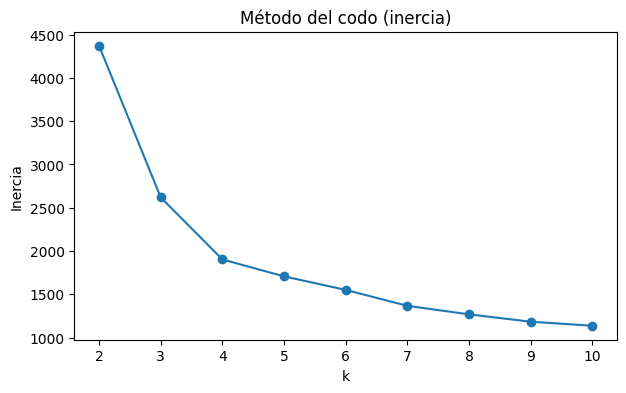

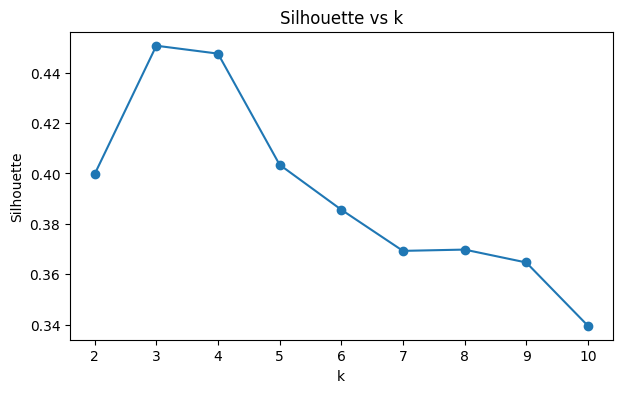

In [3]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

ks = range(2, 11)
inertias = []
sil = []

X_scaled = StandardScaler().fit_transform(df)

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    lbl = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil.append(silhouette_score(X_scaled, lbl))

plt.figure(figsize=(7,4))
plt.plot(list(ks), inertias, marker="o")
plt.title("Método del codo (inercia)")
plt.xlabel("k")
plt.ylabel("Inercia")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(list(ks), sil, marker="o")
plt.title("Silhouette vs k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.show()


## 4) Interpretar segmentos

Una manera práctica: medias por cluster y descripción cualitativa.
Después, traducirlo a acciones (marketing, retención, riesgo, etc.).


In [4]:
summary = df_assign.groupby("cluster").mean().round(2)
summary


,compras_mes,ticket_medio,antiguedad_meses,visitas_web_mes
cluster,,,,
0,11.95,28.23,32.61,29.46
1,5.17,71.51,9.91,11.72
2,2.07,18.35,4.39,6.26
3,8.31,43.18,18.49,19.99


## 5) Visualización 2D con PCA

Reducimos a 2 componentes solo para visualizar (no para entrenar).


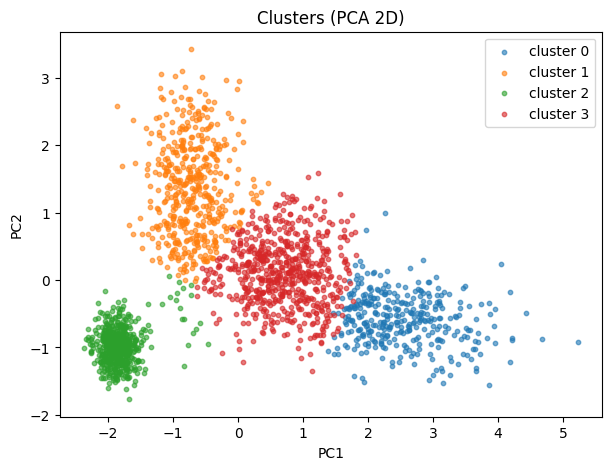

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)

viz = pd.DataFrame(coords, columns=["pc1","pc2"])
viz["cluster"] = labels

import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for c in sorted(viz["cluster"].unique()):
    m = viz["cluster"]==c
    plt.scatter(viz.loc[m,"pc1"], viz.loc[m,"pc2"], s=10, label=f"cluster {c}", alpha=0.6)
plt.title("Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


## Ejercicios

### Ejercicio 1: Segmentación accionable
Elige un k razonado (2–8) y escribe un párrafo por cluster describiendo el segmento y una acción concreta (p.ej., campaña, retención, upselling, control de riesgo).

**Entregables**
- k elegido y justificación
- Descripción + acción por cluster

**Criterios de evaluación**
- Justificación coherente con métricas
- Segmentos interpretables
- Acciones específicas y realistas


In [6]:
# =========================
# 1. Resumen por cluster
# =========================
summary = (
    df_assign
    .groupby("cluster")
    .agg(
        clientes=("compras_mes", "count"),
        compras_mes=("compras_mes", "mean"),
        ticket_medio=("ticket_medio", "mean"),
        antiguedad_meses=("antiguedad_meses", "mean"),
        visitas_web_mes=("visitas_web_mes", "mean")
    )
    .round(2)
)

# porcentaje de clientes
summary["pct_clientes"] = (
    summary["clientes"] / summary["clientes"].sum() * 100
).round(1)

summary


,clientes,compras_mes,ticket_medio,antiguedad_meses,visitas_web_mes,pct_clientes
cluster,,,,,,
0,350,11.95,28.23,32.61,29.46,17.5
1,484,5.17,71.51,9.91,11.72,24.2
2,531,2.07,18.35,4.39,6.26,26.6
3,635,8.31,43.18,18.49,19.99,31.8


In [7]:
# =========================
# 2. Etiquetas de negocio y acciones
# =========================
cluster_labels = {
    0: "Ocasionales bajo valor",
    1: "Fieles alto valor",
    2: "Premium esporádicos",
    3: "Muy activos sensibles a precio"
}

cluster_actions = {
    0: "Activación: cupón 1ª recompra y productos básicos",
    1: "Fidelización y upselling: premium, cross-sell",
    2: "Recompra dirigida: recordatorios personalizados",
    3: "Control de rentabilidad: bundles y menos descuentos"
}

summary["segmento"] = summary.index.map(cluster_labels)
summary["accion_recomendada"] = summary.index.map(cluster_actions)

summary


,clientes,compras_mes,ticket_medio,antiguedad_meses,visitas_web_mes,pct_clientes,segmento,accion_recomendada
cluster,,,,,,,,
0,350,11.95,28.23,32.61,29.46,17.5,Ocasionales bajo valor,Activación: cupón 1ª recompra y productos básicos
1,484,5.17,71.51,9.91,11.72,24.2,Fieles alto valor,"Fidelización y upselling: premium, cross-sell"
2,531,2.07,18.35,4.39,6.26,26.6,Premium esporádicos,Recompra dirigida: recordatorios personalizados
3,635,8.31,43.18,18.49,19.99,31.8,Muy activos sensibles a precio,Control de rentabilidad: bundles y menos descu...


In [8]:
# =========================
# 3. Ver todo junto (tabla final)
# =========================
cols = [
    "segmento", "clientes", "pct_clientes",
    "compras_mes", "ticket_medio",
    "antiguedad_meses", "visitas_web_mes",
    "accion_recomendada"
]

summary[cols]


,segmento,clientes,pct_clientes,compras_mes,ticket_medio,antiguedad_meses,visitas_web_mes,accion_recomendada
cluster,,,,,,,,
0,Ocasionales bajo valor,350,17.5,11.95,28.23,32.61,29.46,Activación: cupón 1ª recompra y productos básicos
1,Fieles alto valor,484,24.2,5.17,71.51,9.91,11.72,"Fidelización y upselling: premium, cross-sell"
2,Premium esporádicos,531,26.6,2.07,18.35,4.39,6.26,Recompra dirigida: recordatorios personalizados
3,Muy activos sensibles a precio,635,31.8,8.31,43.18,18.49,19.99,Control de rentabilidad: bundles y menos descu...


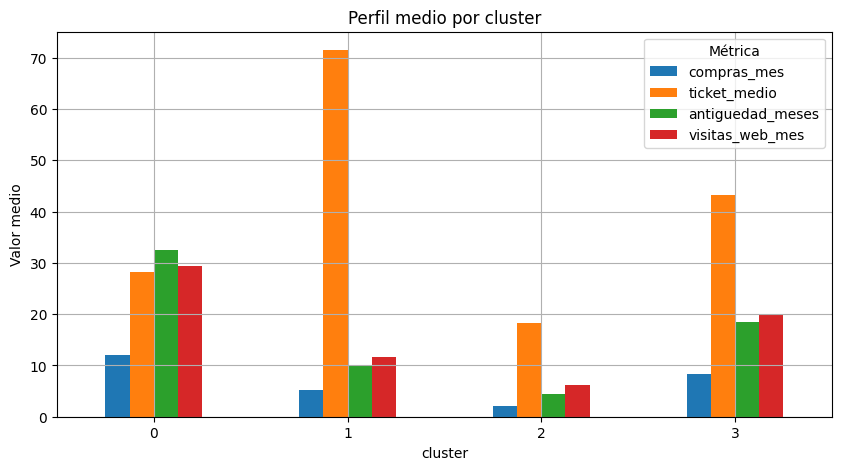

In [9]:
# =========================
# 4. Visualización clara por métricas
# =========================
import matplotlib.pyplot as plt

metrics = [
    "compras_mes",
    "ticket_medio",
    "antiguedad_meses",
    "visitas_web_mes"
]

summary[metrics].plot(
    kind="bar",
    figsize=(10,5),
    grid=True
)

plt.title("Perfil medio por cluster")
plt.ylabel("Valor medio")
plt.xticks(rotation=0)
plt.legend(title="Métrica")
plt.show()


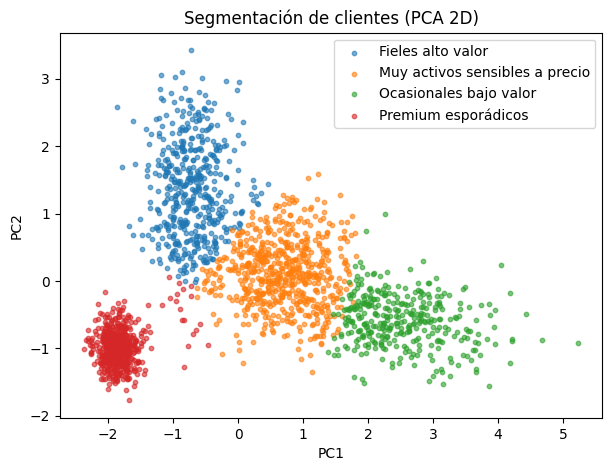

In [10]:
# =========================
# 5. PCA 2D con nombres de segmento
# =========================
viz_named = viz.copy()
viz_named["segmento"] = viz_named["cluster"].map(cluster_labels)

plt.figure(figsize=(7,5))
for seg_name in viz_named["segmento"].unique():
    m = viz_named["segmento"] == seg_name
    plt.scatter(
        viz_named.loc[m, "pc1"],
        viz_named.loc[m, "pc2"],
        s=10,
        alpha=0.6,
        label=seg_name
    )

plt.title("Segmentación de clientes (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()



### Ejercicio 2: Comparar con otro algoritmo
Prueba `DBSCAN` o `GaussianMixture` y compara: ¿qué cambia en número de grupos y en interpretabilidad?

**Entregables**
- Resultado del modelo alternativo
- Comparación cualitativa y, si aplica, silhouette

**Criterios de evaluación**
- Configuración razonada
- Comparación clara
- Se mencionan limitaciones


In [11]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd

X_scaled = StandardScaler().fit_transform(df)

ks = range(2, 9)
bic = []
sil_gmm = []

for k in ks:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=42
    )
    labels_gmm = gmm.fit_predict(X_scaled)
    bic.append(gmm.bic(X_scaled))
    sil_gmm.append(silhouette_score(X_scaled, labels_gmm))

results = pd.DataFrame({
    "k": ks,
    "BIC": bic,
    "Silhouette": sil_gmm
})

results


,k,BIC,Silhouette
0,2,15327.047601,0.355719
1,3,13666.126748,0.443512
2,4,13443.030796,0.429330
3,5,13554.514751,0.378770
4,6,13661.136101,0.365216
5,7,13754.176420,0.344833
6,8,13856.452757,0.352264


In [12]:
gmm = GaussianMixture(
    n_components=4,
    covariance_type="full",
    random_state=42
)

labels_gmm = gmm.fit_predict(X_scaled)

df_gmm = df.copy()
df_gmm["cluster"] = labels_gmm

df_gmm["cluster"].value_counts()


cluster
3    611
2    513
1    496
0    380
Name: count, dtype: int64

In [13]:
summary_gmm = df_gmm.groupby("cluster").mean().round(2)
summary_gmm


,compras_mes,ticket_medio,antiguedad_meses,visitas_web_mes
cluster,,,,
0,12.09,27.74,31.09,28.26
1,5.02,69.32,9.99,11.65
2,1.98,17.94,4.19,6.10
3,8.12,45.05,18.60,20.21


El uso de Gaussian Mixture confirma la existencia de 4 segmentos, coherentes con KMeans.
La principal diferencia es que GMM ofrece una asignación probabilística y clusters más flexibles, a costa de menor simplicidad.
Para segmentación accionable y comunicación con negocio, KMeans es preferible; para scoring o análisis avanzado, GMM aporta valor adicional.